In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from imaids.models import DeltaSabia
from imaids.shimming import UndulatorShimming
from imaids.insertiondevice import InsertionDeviceData

%config InLineBackends.figure_format = ['svg']
mpl.rcParams['font.size'] = 9

<a id="index"></a> <h1>Index</h1>

[1. General Description of the Shimming Process](#1) <br>
&emsp; [1.1. Optmized Parameters](#1.1) <br>
&emsp; [1.2. The Shims](#1.2) <br>
&emsp; [1.3. Finding the Shims](#1.3) <br>
[2. Creating the necessary objects](#2) <br>
&emsp; [2.1 Creating the Model Object](#2.1) <br>
&emsp; [2.2 Creating the Data Object](#2.2) <br>
&emsp; [2.3 Creating the Shimming Object](#2.3) <br>
&emsp; [2.4 Rescaling the Model Object](#2.4) <br>
&emsp; [2.5 Visualizing Model and Data Objects](#2.5) <br>
[3. Calculating Shimming Values](#3) <br>
[4. Visualizing Shimming](#4) <br>
[5. Loading Results from Files](#5) <br>

<a id="1"></a> <h1>1. General Description of the Shimming Process [&#10548;](#index)</h1>

<a id="1.1"></a> <h2>1.1. The Optimized Parameters (*errors*) [&#10548;](#index)</h2>

The shimming procedure, as implemented at `imaids`, optimizes **trajectory slopes** and, optionally, also **phase errors**:

> **Trajectory slopes** are average $x$ and $y$ slopes (inclination of linear fits) calculated over trajectory sections, or *segments*. Such average segment slopes represent general displacement trends at the trajectory.
> 
> The limiting points for the segments are defined automatically using methods of the shimming module. In such case, the slopes are <span style="color:orangered">defined by the trajectory zeros</span>. A string input argument named `segments_type` ([see bellow](#2.5.parameters)) defines wether segment limits are defined by every zero (`segment_type='half_period'`) or by every other zero (`segment_type='period'`).

> **Phase errors** are the phase mismatches between the actual phase delay of the electron beam with respect to the emitted radiation and the ideal phase delay for the constructing interference regime of an undulator. A boolean input argument named `include_pe` controls wether phase errors are included for shimming determination.
> 
> Such errors are calculated internally by the `SinusoidalFieldSource.calc_phase_error` method for *poles*, which are points <span style="color:orangered">defined as trajectory points with zero derivative</span>.

The component used for determining segment limits and poles is set by the input `field_comp`, with the values `1` (meaning $B_x==0$ for segment limits and $y'=0$ for poles), `0` ($B_y==0$ and $x'=0$), or `None` (maximum field amplitude and corresponding velocity zero used) ([see bellow](#2.5.parameters)). 

<div class="alert alert-block alert-info">
    Both <b>trajectory slopes</b> and <b>phase errors</b> are aimed to be <span style="color:darkgreen;font-weight:bold">minimized</span> by the shimming procedure and are collective referred to as <b>errors</b>.
</div>

When treated by the shimming script, such errors are stored in an **errors vector**. Considering $M$ slopes in each direction ($x$ and $y$) labeled ${sx}_n$, ${sy}_n$ and $N$ phase errors ($N$ poles) labeled by ${pe}_i$, the vector will be:

$$\textbf{errors} = \left( { \begin{array}{c}
                            {sx}_0 \\ \vdots \\ {sx}_M \\
                            {sy}_0 \\ \vdots \\ {sy}_M \\
                            {pe}_0 \\ \vdots \\ {pe}_N \\
                              \end{array} }\right)$$

**Note:** the errors vector calculated by the shimming function contains the errors calculated for the real device (using the measured field) from which the same errors calculated for an ideal Radia model were subtracted. This way, the errors would be equal to zero if the measurement were to match the Radia model (ideal) exactly.

<a id="1.2"></a> <h2>1.2. The Shims [&#10548;](#index)</h2>

The shimms, small shifts applied to the blocks, are specified in the local coordinate system of the blocks, in which $y+$, *up* is the longitudinal direction which points to the device's central axis. (e.g. $y+$ is the global *up* ($y+$) for the lower cassette and the global *down* ($y-$) for the upper cassette in a planar undulator with central axis along $z+$).

The blocks used for shimming are selected from a given set of cassettes with respect to a given block type. Such block type is specified by a string input parameter named `block_type` ([see bellow](#2.5.parameters)) for which the current implemented options allow for the usage of:
- "vertical blocks" (`'v'`, `'vpos'`, `'vneg'`), which may include all the blocks with magnetization on the $y$ direction, or only the ones on the $y+$ or $y-$ direction. In this case, <span style="color:orangered">a "shim" is the displacement of a single block</span>. This is the usual option.
- "vertical-longitudinal pairs" (`'vlpair'`), a further option in which the shims are applied in pairs of blocks. Each pair consist of a vertical block and the longitudinal block, which are always moved together. In this case, <span style="color:orangered">a "shim" is the displacement of a pair of blocks</span>.

The total number of shims ($K$) depends on the number of periods in the undulator, the selected cassettes, and the block type. Just like the errors, the shims are grouped in a **shims vector**:


$$\textbf{shims} = \left( { \begin{array}{c} {shim}_0 \\ \vdots \\ {shim}_K \\ \end{array} }\right)$$

**The shimming calculation objective is to find the shims vector which minimizes the error vector in a given device.**

<a id="1.3"></a> <h2>1.3. Finding the Shims [&#10548;](#index)</h2>

<div class="alert alert-block alert-info">
     The process of finding the optimizing shims is based on:
    <ul>
        <li>an error vector calculated from a magnetic measurement of the real device</li>
        <li>a response matrix relating the shims to the errors on a Radia model of the device</li>
    </ul>
   <p>
       The response matrix is used for determining the shims associated to the observed errors from the measurement, which can then be undone.

</div>

The **response matrix** is calculated by:
 1. Calculating the errors vector for the original (not shimmed) Radia model: $\textbf{errors}^{(0)}$<br>
 2. For each shim (*k-th* shim):<br>
     2.1. Apply shim (displace block or pair of blocks by a given $\Delta s$ shift).<br>
     2.2. Calculate errors vector for the device: $\textbf{errors}^{(k)}$<br>
     2.3. Undo shim.<br>
     2.4. Calculate shim effect derivative: $ \dfrac{\textbf{errors}^{(k)}-\textbf{errors}^{(0)}}{\Delta s} = \dfrac{\Delta \textbf{errors}^{(k)}}{\Delta s}$
     
The resulting $\dfrac{{\Delta \textbf{errors}}}{\Delta s}$ vector has the form:

$$\dfrac{\Delta \textbf{errors}^{(k)}}{\Delta s} = 
            \left( { \begin{array}{c} 
                            \dfrac{{\Delta errors}^{(k)}_{0}}{\Delta s} \\
                            \vdots \\
                            \dfrac{{\Delta errors}^{(k)}_{2M+N}}{\Delta s} \\
                      \end{array} }\right) :=
             \left( { \begin{array}{c} 
                            {D e}^{(k)}_{0} \\
                            \vdots \\
                            {D e}^{(k)}_{2M+N} \\
                      \end{array} }\right)$$

In which each element $ \dfrac{{\Delta errors}^{(k)}_{n}}{\Delta s} = {D e}^{(k)}_{n} $ is a derivative representing the effect of the *k-th* shim on the *n-th* error, there being $K$ shims and $2M+N$ errors, associated with $M$ segments ($x$ and $y$ slopes) and $N$ phase error poles.

The resulting response matrix, $\mbox{Mat}$, is constructed from such vector derivatives:

$$
\mbox{Mat} = \left( 
{ \begin{array}{ccc}
{D e}^{(0)}_{0} & \dots &  {D e}^{(0)}_{K}\\
\vdots & \ddots & \vdots \\
{D e}^{(2M+N)}_{0} & \dots &  {D e}^{(2M+N)}_{K}\\
\end{array} }
\right)
$$

In such a way that:

$$ \textbf{errors} = \mbox{Mat} \cdot \textbf{shims} $$

By inverting the matrix, we can, finally, calculate the shims associated to a given error vector:

$$ \textbf{shims} = {\mbox{Mat}}^{-1} \cdot \textbf{errors} $$

The inverse matrix is found by using a **singular value decomposition method** (SVD), which defines an approximate pseudo-inverse matrix, even when a proper inverse does not exist, as for the non-square matrices usually dealt with here. This method decomposes the original matrix on the form:

$$ 
\mbox{Mat} = U \cdot \Sigma \cdot V^{*}
$$

In which $U$ and $V$ are invertible unitary matrices ($U^*U=V^*V=\mathbb{1}$), and $\Sigma$ is a rectangular diagonal matrix, populated by the **singular values** $\sigma_i$, of the form:

$$
\Sigma = \left( 
{ \begin{array}{cccc}
\sigma_1 & 0 & \dots & 0 \\
0 & \sigma_2 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \sigma_{\mbox{nsv}} \\
0 & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 0 \\
\end{array} }
\right)
$$

or:

$$
\Sigma = \left( 
{ \begin{array}{cccccc}
\sigma_1 & 0 & \dots & 0 & \dots & 0 \\
0 & \sigma_2 & \dots & 0 & \dots & 0\\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots\\
0 & 0 & \dots & \sigma_{\mbox{nsv}} & \dots & 0\\
\end{array} }
\right)
$$

Depending on the dimension sizes (wether there are more shims or errors, in our case).

The inverse matrix is than approximated by a *pseudoinverse* of the form (assuming more shims than errors):

$$ {\mbox{Mat}}^{-1} = V \cdot \Sigma^{\dagger} \cdot U^{*} = 
V \cdot
\left( 
{ \begin{array}{cccc}
\sigma_1^{-1} & 0 & \dots & 0 \\
0 & \sigma_2^{-1} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \sigma_{\mbox{nsv}}^{-1} \\
0 & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 0 \\
\end{array} }
\right)
\cdot U^{*}
$$

<span style="color:orangered"><b>Important:</b></span> The singular values are ordered from the larger to the smaller value in an array `[sv[0], ...]` which usually contains a set of very small values compared to the first ones (see example [bellow](#nsv)). For better results such smaller values must be eliminated, which is done by setting a `'nsv'` parameter which determines a number o singular values smaller than the total number found by the SVD. The first `'nsv'` values are then used and the remaining ones set to `0` (which is, effectively, approximating the original matrix by eliminating small components through changing the matrix $\Sigma$).

<a id="2"></a> <h1>2. Creating the Necessary Objects [&#10548;](#index)</h1>

The shimming calculation utilizes two field source objects:

* An ```InsertionDeviceData``` **data object** created from measured data of device to be shimmed.
* An ```InsertionDeviceModel``` **model object** related to a Radia model that represents the shimmed device.

> The data used in this example comes from a **Delta Sabia** model in a **circular polarization** and **maximum K** state.

Also, a **shimming object** must be created, which is an instance of the ```UndulatorShimming``` class. Such object stores a general set of parameters used throughout the shimming steps and a set of method for performing such steps

<a id="2.1"></a> <h2>2.1. Creating the Model Object [&#10548;](#index)</h2>

The model object should be an instance of any ```InsertionDeviceModel``` subclass. Here, we use the available delta sabia class.

In [2]:
model = DeltaSabia()

For a practical shimming procedure, blocks should be identified by their **names**.

Block names must be set by the ```create_radia_object``` method and are given as a **dictionary of block names lists (one per cassette)**.

For producing a clearer example, blocks will be named by their cassette name and a sequential ```n``` number: ```"{cassette}_block_{n}"```.

In [3]:
block_names = { 'cse': [f'cse_block_{n}' for n in range(len(model.cassettes['cse'].blocks))],
                'csd': [f'csd_block_{n}' for n in range(len(model.cassettes['csd'].blocks))],
                'cie': [f'cie_block_{n}' for n in range(len(model.cassettes['cie'].blocks))],
                'cid': [f'cid_block_{n}' for n in range(len(model.cassettes['cid'].blocks))] }

The dictionary of block names must be passed to the object through the ```create_radia_object``` method:

In [4]:
model.create_radia_object(block_names_dict=block_names)

Finally, we set the cassettes position to the  **circular polarization** and **maximum K** state in which the measurement has been made. For our case, this is achieved by performing a phase-type movement (```dp```) and a GV-type movement (```dgv```).

In [5]:
model.set_cassete_positions(dp = -13.125,
                            dgv = 26.250);

<a id="2.2"></a> <h2>2.2. Creating the Data Object [&#10548;](#index)</h2>

For creating the ```InsertionDeviceData``` object, the device parameters must be provided along with the data.

The parameters set at this step are the path to the data file (```meas_filename```) and, optionally, the selected $y$ value from the data (```selected_y```). 

The remaining arguments describe insertion device properties. Here, we use the attributes from the **model object**, since it matches the measured data device.

In [6]:
meas = InsertionDeviceData(filename = 'd52_cp_kmax.dat',
                           selected_y = 0,
                           nr_periods = model.nr_periods,
                           period_length = model.period_length,
                           gap = model.gap)

<a id="2.3"></a> <h2>2.3. Creating the Shimming Object [&#10548;](#index)</h2>

The main functions for performing the shimming process are methods of the ```UndulatorShimming``` class.

Objects of such class also store general attributes for a shimming calculation. Such attributes are given at object initialization. They are:

<a id="2.5.parameters"></a>

- `zmin`, `zmax` and `znpts` : minimum, maximunm and sampling (number of points) for longitudinal coordinate, used for calculating fields, field integrals and trajetories.
- `rkstep` and `energy` : Runge-Kutta step and energy (in KeV) for trajectory calculations. Energy has a default *3 GeV* value.
- `include_pe` : boolean value, if True phase errors are included in the shimming procedure.
- `zmin_pe` and `zmax_pe` : lower and upper z bounds for poles in phase error calculation. If not given (`None`), are automatically set equal to `zmin` and `zmax`.
- `cassettes` : list of cassettes from which shimmed blocks will be selected.
- `block_type` :  string defining type of block for shimming. Might be `'v'` (all blocks with magnetization in the the $y$ direction), `'vpos'` (only the ones pointing in the $+y$ direction) or `'vneg'`, only the ones pointing in the $-y$ direction.
- `segments_type` : when defining segments for slopes determination, segment limits are determined by trajectory zeros according to the value of this parameter:
    - `segments_type==`'period'` : segment limits are defined by every other trajectory zero.
    - `segments_type==`'half_period'` : segment limits are defined all the trajectory zeros.
- `field_comp` : defines field component used for determining poles in phase error calculations,  field zeros in segment limits determination and amplitudes in model object rescaling (see bellow). May be:
    - `field_comp==0`:
        - $B_x$ component used for poles (meaning trajectory $y'=0$).
        - $B_x$ component used for segment limits.
        - $B_x$ amplitude used for determining radia object magnetization rescaling.
    - `field_comp==1`:
        - $B_y$ component used for poles (meaning trajectory $x'=0$).
        - $B_y$ component used for segment limits.
        - $B_y$ amplitude used for determining radia object magnetization rescaling.
    - `field_comp==None`: (default)
        - greater amplitude component used for poles (meaning corresponding $y'=0$ or $x'=0$ for trajectory).
        - greater amplitude component used for segment limits.
        - $\sqrt{B_x + B_y}$ amplitude used for determining radia object magnetization rescaling.
- `solved_matrix` : boolean value determining wether `solve()` is run for calculating the response matrix (after displacing each block).
- `solved_shim` : boolean value determining wether `solve()` is run for calculating shim signatures.

In [7]:
sh = UndulatorShimming(
        zmin = -900,
        zmax = 900,
        znpts = 901,
        rkstep = 0.5,
        energy = 3.0,
        include_pe = True,
        zmin_pe = -530,
        zmax_pe = 550,
        cassettes = ['csd', 'cse'],
        block_type = 'v',
        segments_type = 'half_period',
        field_comp = 1,
        solved_matrix = True,
        solved_shim = True)

<a id="2.4"></a> <h2>2.4. Rescaling the Model Object [&#10548;](#index)</h2>

If there is a global scale difference between the magnetic field from the model and data objects, such difference should be eliminated, since it is harder to remove it by using the shimming alone.

This is done by rescaling the model blocks magnetization modulus by a constant factor (```resf```) such that its field amplitudes match the amplitudes from the data object.
<br>The `calc_rescale_factor` method takes the `model` and `meas` objects as arguments, calculates their field amplitudes and returns the scaling factor.

A log of the rescaling calculation may be, optionally, saved to a file by specifying the `filename` keyword argument. Such log is saved in JSON format in which the rescaling factor is keyed by a `'fres'` string.

In [8]:
print('Caculating amplitudes for rescale factor...')
resf = sh.calc_rescale_factor(model, meas, filename='rescale_log.json')
print('> Rescale factor:', resf)

mr_resf = model.cassette_properties['mr']*resf
print('> Rescaled mr value:', mr_resf)

# Create new rescaled model using mr_resf while keeping other parameters.
model_res = DeltaSabia(mr=mr_resf,
                       init_radia_object=False)
model_res.create_radia_object(block_names_dict=model.block_names_dict)
model_res.dgv = model.dgv
model_res.dp = model.dp
print('Executing solve() for rescaled object...')
model_res.solve()
print('> Done')

Caculating amplitudes for rescale factor...
> Rescale factor: 0.9429494926604503
> Rescaled mr value: 1.3106997947980257
Executing solve() for rescaled object...
> Done


<a id="2.5"></a> <h2>2.5 Visualizing Model and Data Objects [&#10548;](#index)</h2>

The cell bellow prints the name and longitudinal position of the first and last blocks in each cassette. This illustrates the relationship between the sequential block names and their position: blocks are arranged from the back (minium z) to the front (maximum z) of the undulator in each cassette.

The field profile from the model and measurement objects are also plotted.

> Cassette: cse
name: cse_block_0     position: -596.825
name: cse_block_1     position: -585.175
name: cse_block_2     position: -576.675
 ...
name: cse_block_90    position:  576.675
name: cse_block_91    position:  585.175
name: cse_block_92    position:  596.825
────────────────────────────────────────
> Cassette: csd
name: csd_block_0     position: -596.825
name: csd_block_1     position: -585.175
name: csd_block_2     position: -576.675
 ...
name: csd_block_90    position:  576.675
name: csd_block_91    position:  585.175
name: csd_block_92    position:  596.825
────────────────────────────────────────
> Cassette: cie
name: cie_block_0     position: -596.825
name: cie_block_1     position: -585.175
name: cie_block_2     position: -576.675
 ...
name: cie_block_90    position:  576.675
name: cie_block_91    position:  585.175
name: cie_block_92    position:  596.825
────────────────────────────────────────
> Cassette: cid
name: cid_block_0     position: -596.825
name: cid_block_1  

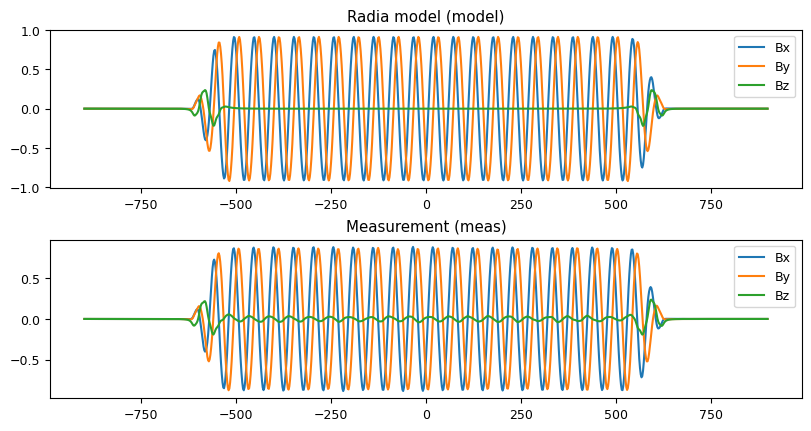

In [9]:
for cas in model.cassettes.keys():
    print(f'> Cassette: {cas}')
    for block in model.cassettes[cas].blocks[:3]:
        print(f'name: {block.name:<15} position: {block.longitudinal_position:>8.3f}')
    print(' ...')
    for block in model.cassettes[cas].blocks[-3:]:
        print(f'name: {block.name:<15} position: {block.longitudinal_position:>8.3f}')
    print('─'*40)

z = np.linspace(-900, 900, 901)
fig, ax = plt.subplots(2,1,figsize=(8,4.2), constrained_layout=True)
ax[0].plot(z, model.get_field(z=z), label=['Bx', 'By', 'Bz'])
ax[0].legend()
ax[0].set_title('Radia model (model)')
ax[1].plot(z, meas.get_field(z=z), label=['Bx', 'By', 'Bz'])
ax[1].legend()
ax[1].set_title('Measurement (meas)');

<a id="3"></a> <h1>3. Calculating Shimming Values[&#10548;](#index)</h1>            

The first step on the shims calculation is determining the segments used for calculating slopes. This is done by the `calc_segments`method.

This method determines segment limits as a list of segment limits, determined as the zeros of a trajectory calculated between `zmin` and `zmax` using the component determined by `field_comp` and in the manner determined by `segments_type`

The output may be, optionally, saved to a file by specifying the `filename` keyword argument.

In [10]:
segs = sh.calc_segments(model, filename='segs.dat')
# Visualizing segs list
for seg in segs:
    print(f'{seg:.3f}', end=', ')

-667.168, -614.668, -586.631, -559.051, -531.889, -505.287, -479.065, -452.814, -426.566, -400.316, -374.064, -347.810, -321.559, -295.310, -269.062, -242.814, -216.566, -190.316, -164.064, -137.810, -111.559, -85.310, -59.062, -32.814, -6.566, 19.684, 45.936, 72.190, 98.441, 124.690, 150.938, 177.186, 203.434, 229.684, 255.936, 282.190, 308.441, 334.690, 360.938, 387.186, 413.434, 439.684, 465.936, 492.193, 518.419, 545.018, 572.159, 599.735, 627.726, 680.226, 

Segments and the Radia model imaids object are then passed to the `calc_response_matrix` method. Such method determines the response matrix as detailed in the [section 1.3](#1.3). The remaining necessary inputs to the calculation are given by the `sh` shimming object attributes. These include `include_pe`, which determines if the resulting matrix will contain rows associated with phase errors.

While the matrix is being calculated, intermediary files with prefixes *"_mx"*, *"_my"* and *"_mpe"* are created, storing results for slopes and phase error rows. The final response matrix is then saved to a `filename` file after its computation is donw.

In [11]:
matrix = sh.calc_response_matrix(model, segs, filename='matrix.dat')

<a id="nsv"></a>The singular value decomposition is performed internally by the shims calculation method later on. However, at this step we may already visualize the singular values of the response matrix so that we can determine the number of singular values to be used (`nsv`).

The singular values are calculated bellow by the `calc_svd` method from the shimming object. Such method returns the matrices $U$, $\Sigma$ and $V^{*}$, as described in [section 1.3](#1.3).

The $\Sigma$ matrix is represented by a singular values vector, stored in `sv` and plotted bellow.

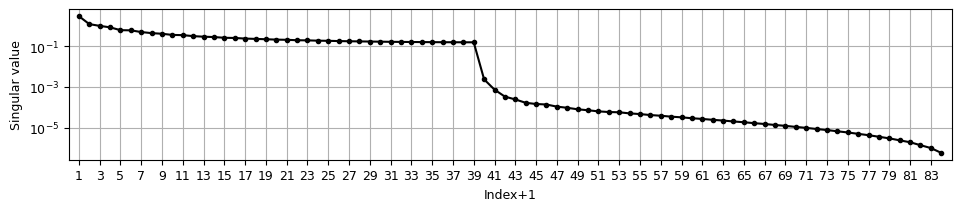

In [12]:
_, sv, _ = UndulatorShimming.calc_svd(matrix)
fix, ax = plt.subplots(figsize=(9.5,2), constrained_layout=True)
ax.plot(np.arange(1, len(sv)+1), sv, '.-', c='k')
ax.set_xlabel('Index+1')
ax.set_ylabel('Singular value')
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_yscale('log')
ax.set_xticks(np.arange(1,len(sv)+1, 2))
ax.set_xlim([0, 85])
ax.grid();

The plot shows a quick drop at the 40th singular value, after which singular values are at least 100x smaller than the pervious ones. THerefor, we choose `nsv = 40` when calculating the shims bellow, so that the singular values above 40 are set to `0.0`.

The errors vector are calculated directly through the `calc_error` method. The method returns an error vector containing segment slopes and (possibly, if `include_pe==True`) phase errors calculated for the **data object** (`meas`) after subtraction by the values calculated for the **model object** (as mentioned in the final note of [section 1.1](#1.1)).

The method also allows for different segment lists to be used for model and measurement objects and for saving the error vector to a text file, given by the optional keyword argument `filename`.

In [13]:
errors = sh.calc_error(model=model, meas=meas,
                        model_segs=segs, meas_segs=segs,
                        filename='errors.dat')

As shown by the first print statements of the cell bellow, the slope errors are orders of magnitude smaller than the weights vector, what would undesirably skew the results towards correcting only the phase errors.

This problem is eliminated by the usage of a **weights vector**, which has the same length and multiplies the **errors vector**, giving a different weight to each error element.<br>
In the case bellow, we used a weight `=1` for the slope errors and `=2E-8` for the phase errors.

In [14]:
print('Initial values on errors vector (slope errors): ' + str(errors[:3]))
print('Final values on errors vector (phase errors): ' + str(errors[-3:]))

weights = np.array([1.0]*int(matrix.shape[0]))
weights[:len(segs)] = 1
weights[len(segs):2*len(segs)] = 1
weights[2*len(segs):] = 2e-8

print('─'*40)
print('Initial values on weights vector (slope errors): ' + str(weights[:3]))
print('Final values on weights vector (phase errors): ' + str(weights[-3:]))

Initial values on errors vector (slope errors): [-7.23678973e-07  2.16499740e-06  2.29554785e-06]
Final values on errors vector (phase errors): [0.01463174 0.09155837 0.06831842]
────────────────────────────────────────
Initial values on weights vector (slope errors): [1. 1. 1.]
Final values on weights vector (phase errors): [2.e-08 2.e-08 2.e-08]


Finally, the shims are calculated by a `calc_shims` method, which takes the response matrix (`response_matrix`), errors vector (`error`), number of singular values (`nsv`) and weights vector (`ws`) as inputs.<br>
Again, the results might be saved in a data file though the optional `filename` argument.

In [15]:
shims = sh.calc_shims(response_matrix = matrix,
                      error = errors,
                      nsv = 40,
                      ws = weights,
                      filename = 'shims.dat')

print(shims)

[ 0.1104378  -0.00864443  0.06915692  0.06434386  0.00806501 -0.0302169
 -0.00613349 -0.12487698 -0.05694199 -0.05378781 -0.10449178  0.01820567
 -0.01498311 -0.05219578  0.06838167 -0.06343417 -0.05459692  0.03742627
 -0.19082675  0.06539214 -0.16185549  0.02058499 -0.02901766 -0.02710917
  0.08338155  0.03034343  0.03454929  0.1672505  -0.00361561  0.10149451
  0.1185632  -0.05935587  0.12989246 -0.04287336  0.00948736  0.0185554
 -0.05072534  0.05177703 -0.08124118  0.07675243 -0.06590611  0.0299869
 -0.07317001  0.07876178  0.09176668 -0.00765605  0.05108793  0.00702664
 -0.04234608 -0.15080143  0.07129098 -0.2218872  -0.00149471  0.02043236
 -0.10816068  0.04205071  0.03095128 -0.0816431  -0.00687479  0.00251668
 -0.15327543  0.00854345 -0.08480387 -0.05380443 -0.01175952  0.00674529
  0.01119264  0.07272078  0.03688931  0.11755679  0.057114    0.0528387
  0.1577231  -0.08642184  0.15658215 -0.04705553  0.00254531  0.02139766
 -0.01117602 -0.04330324  0.04248537 -0.02435032 -0.026

<a id="4"></a> <h1>4. Visualizing Shimming[&#10548;](#index)</h1>

The shimming effect visualization aims determining **what the measured field would have looked like if the shims had been applied to it**.

For achieving this result, the following procedure is used:
- The magnetic field is calculated for the unshimmed Radia model.
- The shims are applied to the model and the field is calculated again.
- The original unshimmed field is subtracted from the shimmed field, the result is called the **shimming signature**.
- The shimming signature is added to the measured field data, resulting in the **corrected measurement**.

In the cell bellow, first the signature is calculated by the `calc_shim_signature` method from the model object and calculated shims, then, the corrected measurement is calculated by `calc_shimmed_meas` using the obtained signature.

In [16]:
model_signature = sh.calc_shim_signature(model = model,
                                         shims = shims,
                                         filename = 'field_shim_signature.dat')
meas_corrected = sh.calc_shimmed_meas(meas = meas,
                                      shim_signature = model_signature,
                                      filename = 'field_corrected.dat')

The `calc_results` method takes any list of field source objects and a list of labels. It then calculates trajectories, phase errors and field integrals for all of the objects and stores the results on a nested dictionary.<br>
The results from each object are stored on a dictionary and each dictionary is stored in the dictionary returned by `calc_results` keyed by its label from the input `labels` list.
Finally, the results dictionary might be saved to the path specified in the `fieldname` argument in JSON format.

In [17]:
results = sh.calc_results(objs = [meas, model_signature, meas_corrected],
                          labels = ['meas', 'model_signature', 'meas_corrected'],
                          filename='results.json')

The `plot_results` method is a convenient way of visualizing the results. Note the correction on trajectories, phase errors and field integrals.

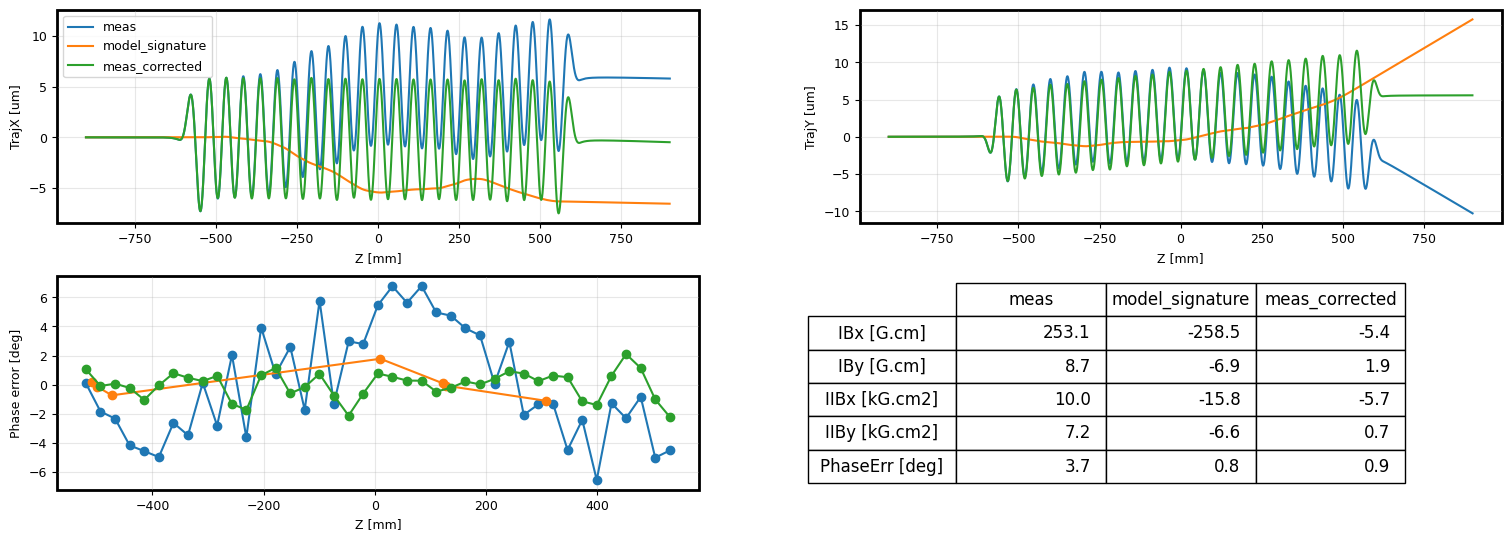

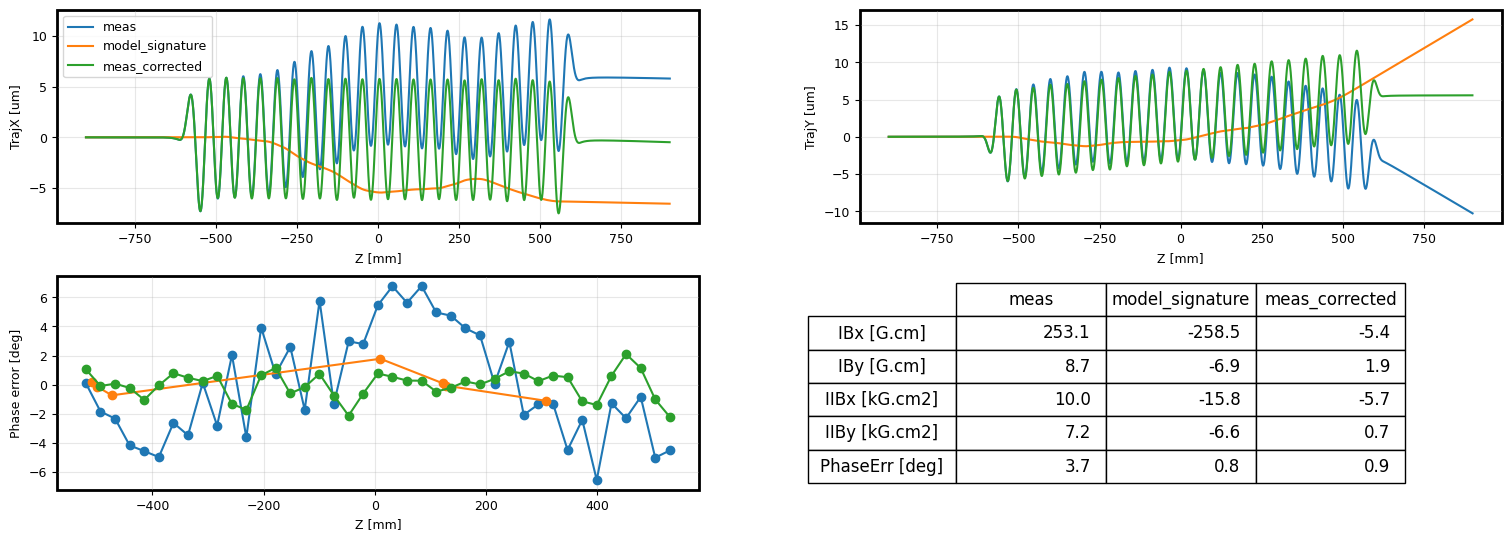

In [18]:
sh.plot_results(results, figsize=(17,6))

<a id="5"></a> <h1>5. Loading Results from Files[&#10548;](#index)</h1>

Since the calculation of the various steps are computationally heavy (mainly, the response matrix), loading the results from saved files might be useful for continuing a calculation from a given step.

There specific method on the shimming object for loading the results for the segments, response matrix, errors and shims. This is illustrated in the cell bellow:

In [19]:
segs_loaded = sh.read_segs('segs.dat')
matrix_loaded = sh.read_response_matrix('matrix.dat')
errors_loaded = sh.read_error('errors.dat')
shims_loaded = sh.read_shims('shims.dat')
model_signature_loaded = sh.read_fieldmap(
                                filename = 'field_shim_signature.dat',
                                nr_periods = model.nr_periods,
                                period = model.period_length,
                                gap = model.gap)
meas_corrected_loaded = sh.read_fieldmap(
                                filename='field_corrected.dat',
                                nr_periods=model.nr_periods,
                                period=model.period_length,
                                gap=model.gap)
results_loaded = sh.read_results('results.json')

E.g. plotting loaded results:

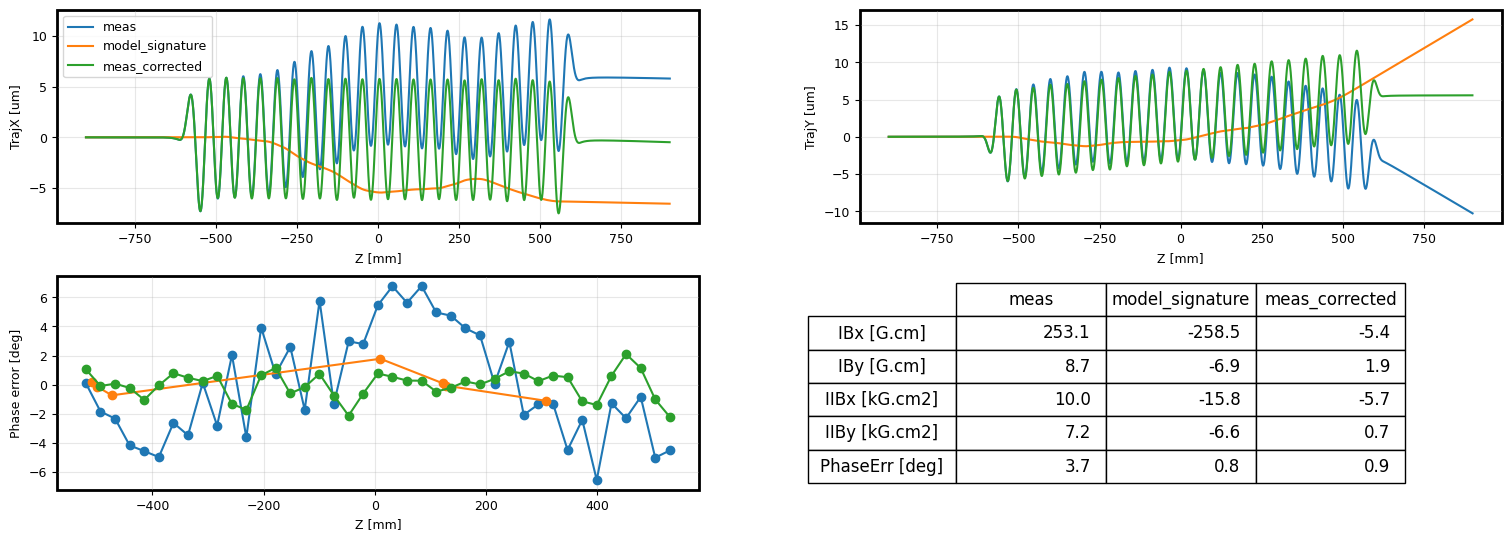

In [20]:
results_figure = sh.plot_results(results_loaded, figsize=(17,6))